# Sacred experiment tracking

1. Train model (M1) on the complete dataset (D1).
2. Split the complete dataset (D1) into the base dataset (D2) and the update dataset (D3).
3. Train a new model (M2) on D2 and update it using D3.
4. Compare M1 and M2
    1. Evaluation M1 and M2 on the complete dataset D1.
    2. TODO: Compare feature importance vectors for individual data points from M1 and M2 (should be very similar)


In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error

from incremental_learning.job import train, update, evaluate
from incremental_learning.config import datasets_dir, root_dir

In [2]:
dataset_name = 'ccpp'

## 1. Train model (M1) on the complete dataset (D1)

In [4]:
%%time
D1 = pd.read_csv(datasets_dir / '{}.csv'.format(dataset_name))
D1.drop_duplicates(inplace=True)

job1 = train(dataset_name, D1, verbose=False)
job1.wait_to_complete()

CPU times: user 145 ms, sys: 160 ms, total: 305 ms
Wall time: 50.6 s


True

## 2. Split the complete dataset (D1) into the base dataset (D2) and the update dataset (D3).

In [5]:
D2, D3 = train_test_split(D1, test_size=0.2)

## 3. Train a new model (M2) on D2 and update it using D3.

In [6]:
%%time
job2 = train(dataset_name, D2, verbose=False)
job2.wait_to_complete()

CPU times: user 57.3 ms, sys: 147 ms, total: 205 ms
Wall time: 50.4 s


True

In [7]:
%%time
job3 = update(dataset_name, D3, job2, verbose=False)
job3.wait_to_complete()

CPU times: user 56.7 ms, sys: 85.1 ms, total: 142 ms
Wall time: 5.28 s


True

## 4. A. Compare M1 and M2 on D1

In [8]:
y_true = D1[job1.dependent_variable]
y_M1 = job1.get_predictions()
eval_job = evaluate(dataset_name, D1, job2, verbose=False)
success = eval_job.wait_to_complete()
if not success:
    print('Evaluation failed')
y_M2 = eval_job.get_predictions()

In [9]:
def compute_metrics(ytrue, m1pred, m2pred):
    m1_mae = mean_absolute_error(ytrue, m1pred)
    m1_mse = mean_squared_error(ytrue, m1pred)
    m2_mae = mean_absolute_error(ytrue, m2pred)
    m2_mse = mean_squared_error(ytrue, m2pred)
    print("M1: MAE: {}\tMSE:{}".format(m1_mae, m1_mse))
    print("M2: MAE: {}\tMSE:{}".format(m2_mae, m2_mse))
    ax = sns.scatterplot(x=m1pred, y=m2pred)
    plt.xlabel('M1 predictions')
    plt.ylabel('M2 predictions')

M1: MAE: 1.2282156759345968	MSE:2.8767663702512154
M2: MAE: 1.5397943598928538	MSE:5.036577216335891


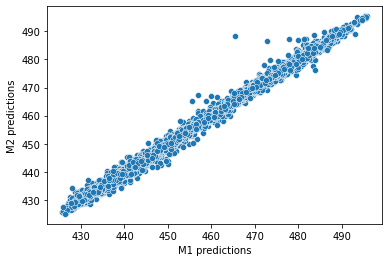

In [10]:
compute_metrics(y_true, y_M1, y_M2)